# Tutorial III Hierarchical Waveform Clustering: the unmixing matrix and reconstruction of scattering coefficients from a feature


After retrieving the most relevant features with an ICA from the scattering coefficients, we can now check what these features are actually telling us. So far, they seem abstract and have no physical unit. However, we can understand better the features, if we look on how they are constructed and how they would reconstruct its input, the scattering coefficients. 

In [26]:
import numpy as np
import pickle
import matplotlib.pylab as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from scipy.signal import medfilt

In [27]:
def load_data():
    
    """Function to load all the data, which is necessary to look at the weights and reconstruction"""

    features = np.load('example/features.npy')
    data = np.load('example/scatnet_output.npz')
    times = data['times']

    with open('example/ica_model.pickle', 'rb') as handle:
        ica_model = pickle.load(handle)

    with open('example/network.pickle', 'rb') as handle:
        network = pickle.load(handle)
        
    return features, times, ica_model, network

In [45]:
def show_weights_feature(weight_type='unmixing', iFeature=0):
    
    features, times, ica_model, network = load_data()

    # information from the scattering network, important for showing the weights later
    size_layer_0 = network.banks[0].octaves*network.banks[0].resolution
    size_layer_1 = network.banks[1].octaves*network.banks[1].resolution
    f_layer_0 = network.banks[0].centers
    f_layer_1 = network.banks[1].centers
    
    # weights of the mixing or unmixing matrix?
    if weight_type == 'mixing':
        weights = ica_model.mixing_.T
    elif weight_type == 'unmixing':
        weights = ica_model.components_
            
    weights_comp = weights[iFeature]

    # the weights are applied to the vectorized scattering coefficients, 
    # here we reshape the weights for the 2nd-order scattering coefficients to assign f_layer_0 and f_layer_1 later
    ic_2ndLayer_e = np.reshape(weights_comp[3*size_layer_0:3*size_layer_0+size_layer_0*size_layer_1], 
                               (size_layer_0,size_layer_1))
    ic_2ndLayer_n = np.reshape(weights_comp[3*size_layer_0+size_layer_0*size_layer_1:3*size_layer_0+size_layer_0*size_layer_1*2], 
                               (size_layer_0,size_layer_1))
    ic_2ndLayer_z = np.reshape(weights_comp[3*size_layer_0+size_layer_0*size_layer_1*2:], 
                               (size_layer_0,size_layer_1))

    ic_2ndLayer = np.array([ic_2ndLayer_e,
                           ic_2ndLayer_n,
                           ic_2ndLayer_z])

    fig = plt.figure(figsize=(10,10))
    gs = GridSpec(3, 3, figure=fig)

    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, :])
    ax3 = fig.add_subplot(gs[2, 0])
    ax4 = fig.add_subplot(gs[2, 1],sharex=ax3,sharey=ax3)
    ax5 = fig.add_subplot(gs[2, 2],sharex=ax3,sharey=ax3)

    ax1.plot(times, medfilt(features[:,iFeature],kernel_size=21), color='k')
    ax1.plot(times, features[:,iFeature], color='k',alpha=0.2)
    ax1.set_xlim(times.min(),times.max())
    ax1.xaxis.set_major_locator(mdates.DayLocator())
    ax1.xaxis.set_minor_locator(mdates.HourLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("\n%Y-%m-%d"))
    ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%HH:%MM"))
    ax1.grid(which='both')
    ax1.set_ylabel('amplitude\nof feature %s' % (iFeature))

    ax2.plot(f_layer_0,weights_comp[:size_layer_0],'-k', label='e-comp')
    ax2.plot(f_layer_0,weights_comp[size_layer_0:2*size_layer_0],'--k', label='n-comp')
    ax2.plot(f_layer_0,weights_comp[2*size_layer_0:3*size_layer_0],':k', label='z-comp')
    ax2.set_xlabel('$f_1$ [Hz]')
    ax2.set_ylabel('weights of\n%s matrix' % weight_type)
    ax2.grid()
    ax2.grid(axis='x', which='minor', color='grey', linestyle='--')
    ax2.set_xscale('log')
    ax2.legend(ncol=3)

    vmin = -np.max(np.abs(weights_comp))
    vmax = np.max(np.abs(weights_comp))
    ax3.set_title('e-comp')
    ax3.pcolormesh(f_layer_0,f_layer_1,ic_2ndLayer_e.T, vmin =vmin,vmax =vmax,cmap='RdBu_r',rasterized=True,shading='auto')
    ax3.set_yscale('log')
    ax3.set_xscale('log')

    ax4.set_title('n-comp')
    ax4.pcolormesh(f_layer_0,f_layer_1,ic_2ndLayer_n.T, vmin =vmin,vmax =vmax,cmap='RdBu_r',rasterized=True,shading='auto')
    ax4.set_yscale('log')
    ax4.set_xscale('log')

    ax5.set_title('z-comp')
    im = ax5.pcolormesh(f_layer_0,f_layer_1,ic_2ndLayer_z.T, vmin =vmin,vmax =vmax,cmap='RdBu_r',rasterized=True,shading='auto')
    ax5.set_yscale('log')
    ax5.set_xscale('log')
    ax3.set_xlabel('$f_1$ [Hz]')
    ax4.set_xlabel('$f_1$ [Hz]')
    ax5.set_xlabel('$f_1$ [Hz]')
    ax3.set_ylabel('$f_2$ [Hz]')
    ax3.set_xlim(np.min(f_layer_0),np.max(f_layer_0))
    ax3.set_ylim(np.min(f_layer_1),np.max(f_layer_1))

    for single_ax in [ax3,ax4,ax5]:
        single_ax.plot(np.linspace(0.1,100,4),np.linspace(0.1,100,4),'--k',lw=2)

    fig.subplots_adjust(right=0.97)
    cbar_ax = fig.add_axes([0.99, 0.075, 0.01, 0.15])
    fig.colorbar(im, cax=cbar_ax)
    cbar_ax.set_ylabel('weights of\n%s matrix' % weight_type)

    fig.tight_layout()
    #plt.show()
    pass

def show_reconstruction(iFeature=0):
    
    features, times, ica_model, network = load_data()
            
    size_layer_0 = network.banks[0].octaves*network.banks[0].resolution
    size_layer_1 = network.banks[1].octaves*network.banks[1].resolution
    f_layer_0 = network.banks[0].centers
    f_layer_1 = network.banks[1].centers
            
    Y_filt = np.zeros(features.shape)
    Y_filt[:,iFeature] = features[:,iFeature]
    sc_filt = ica_model.inverse_transform(Y_filt)

    fig, ax = plt.subplots(3,1,figsize=(15,10),sharex=True,sharey=True)

    vmin_spec=sc_filt[:,:3*size_layer_0].min()
    vmax_spec=sc_filt[:,:3*size_layer_0].max()

    ax[0].pcolormesh(times,f_layer_0,sc_filt[:,:size_layer_0].T,vmin=vmin_spec,vmax=vmax_spec,rasterized=True)
    ax[1].pcolormesh(times,f_layer_0,sc_filt[:,size_layer_0:2*size_layer_0].T,vmin=vmin_spec,vmax=vmax_spec,rasterized=True)
    ax[2].pcolormesh(times,f_layer_0,sc_filt[:,2*size_layer_0:3*size_layer_0].T,vmin=vmin_spec,vmax=vmax_spec,rasterized=True)
    ax[0].set_ylabel('$f_0 [Hz]$')
    ax[1].set_ylabel('$f_0 [Hz]$')
    ax[2].set_ylabel('$f_0 [Hz]$')
    ax[2].xaxis.set_major_locator(mdates.YearLocator())
    ax[2].xaxis.set_minor_locator(mdates.MonthLocator())
    ax[2].xaxis.set_major_formatter(mdates.DateFormatter("\n%Y"))
    ax[2].xaxis.set_minor_formatter(mdates.DateFormatter("%b"))
    ax[2].set_yscale('log')
    plt.show()
    
    pass

/tmp/ipykernel_6801/66478152.py:87: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(right=0.97)
/tmp/ipykernel_6801/66478152.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


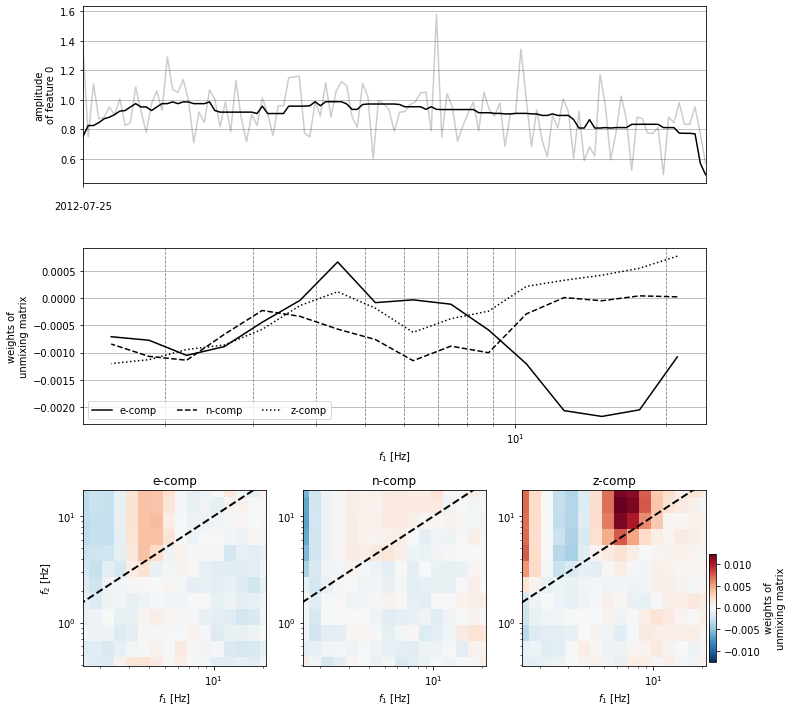

In [46]:
show_weights_feature()

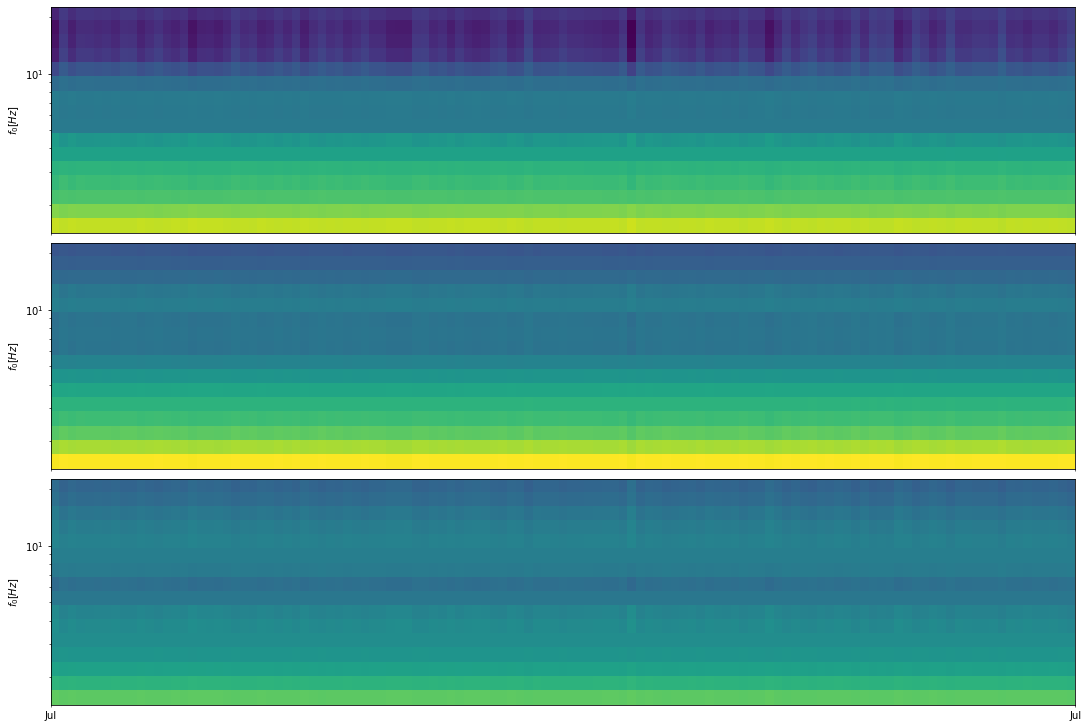

In [47]:
show_reconstruction()